# Imports

In [1]:
import numpy as np
import sklearn as sk
import numpy.random as random
from scipy import stats
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML, Image

from  scipy.optimize import line_search
from functools import partial

from sklearn import model_selection
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor as KNN
import pandas as pd
import math
%matplotlib inline

# Question 1
Give a graphical illustration of the central limit theorem


## Functions to plot the central limit theorem

In [2]:
%matplotlib notebook

#plot the distribution that is sampled
def plotDistribution(distribution):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(0,
                1, 100)
    ax.plot(x, distribution.pdf(x), 'k-', lw=2, label='frozen pdf')
    plt.xlim([0, 1])
    plt.ylim([0,3])
    plt.show()

#run the simulations: calculate the sample means
def runSimulation(distribution,replications,n):
    means = np.zeros(replications)
    for i in range(0,replications):
        sample = distribution.rvs(size=n)
        means[i]=np.average(sample)
    return means

#plot the distribution of the sample means vs the theoretical distributions
def plotCLT(distribution,means):  
    plt.figure()
    
    plt.hist(means,rwidth=0.95,density=True)

    mu=distribution.stats('m')
    var=distribution.stats('v')
    x= np.linspace(mu-(3*math.sqrt(1/n*var)),
                    mu+(3*math.sqrt(1/n*var)), 1000)

    cltdist=stats.norm(mu,math.sqrt(1/n*var))
    plt.plot(x, cltdist.pdf(x), 'k-', lw=2)
    plt.show()

#Animate the histogram of the central limit theorem
def animateCLT(means,replications,nFrames=100,nSec=10):
    def clt(current):
    # if animation is at the last frame, stop it
    
        plt.cla()
        if current == replications: 
            a.event_source.stop()

        plt.hist(means[0:math.floor(current/nFrames*replications)],rwidth=0.95)
        plt.gca().set_title('Distribution sample means')
        plt.gca().set_xlabel('Sample mean')
        plt.gca().set_ylabel('Frequency')

    
    anim = animation.FuncAnimation(plt.figure(), clt,frames=nFrames,repeat=False, interval=((nSec*1000)/nFrames))
    return anim



## Examples of the plot functions
In the first example, we plot the the distribution, the histogram of sample means vs the theoretical distribution and an animation of the CLT. Note that to see the animation the cells needs to be rerun.

<IPython.core.display.Javascript object>


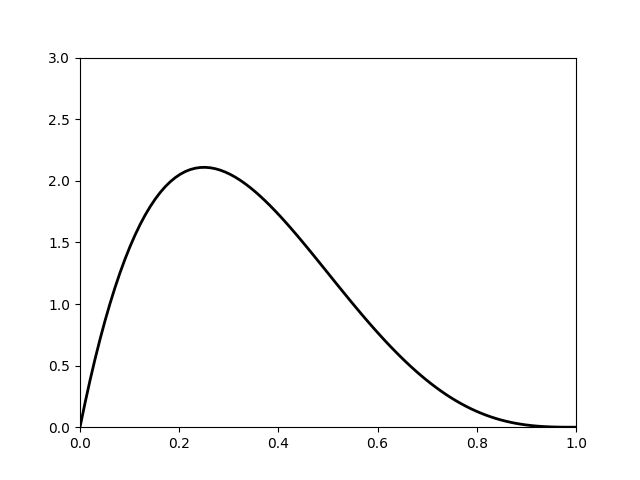

<IPython.core.display.Javascript object>


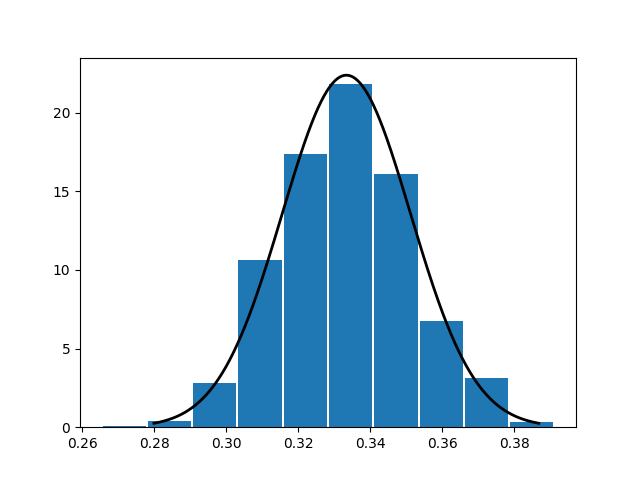

<IPython.core.display.Javascript object>


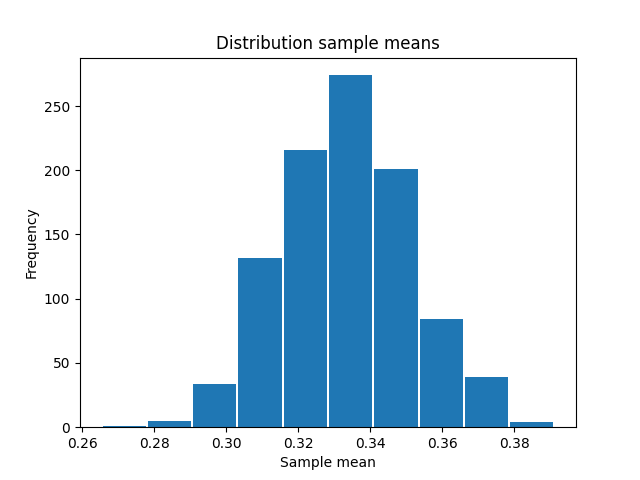

In [3]:
a=2;b=4 #choose parameters a,b of the beta distribution a>0,b>0 
replications=1000 #the number of samples
n=100 #the number of observations in each sample

distribution = stats.beta(a, b)
plotDistribution(distribution)
means=runSimulation(distribution,replications,n)
plotCLT(distribution,means)
anim=animateCLT(means,replications)
plt.show()

Second example: we plot the distrbution for an increasing number of observation per sample. We observe that the distribution of the samplemeans is increasingly concentrated around the true value. This is exactly what we expect since the variance is inversely proportional to the number of observations

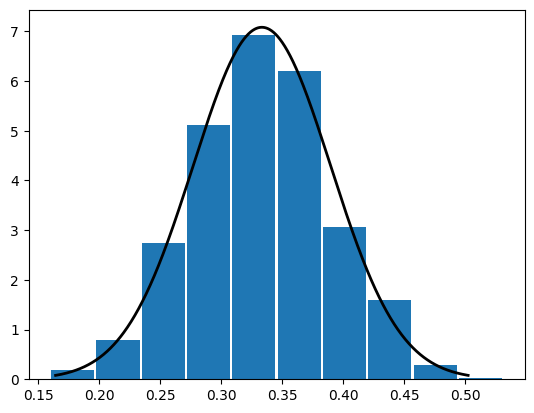

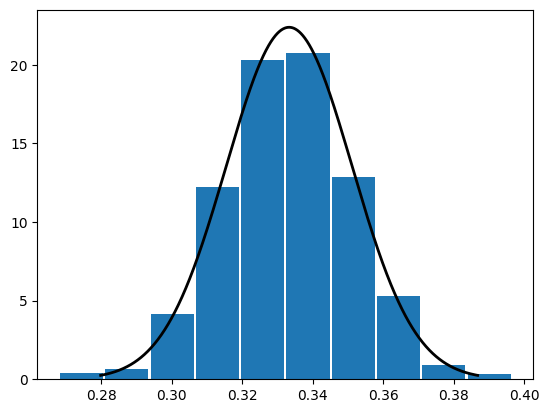

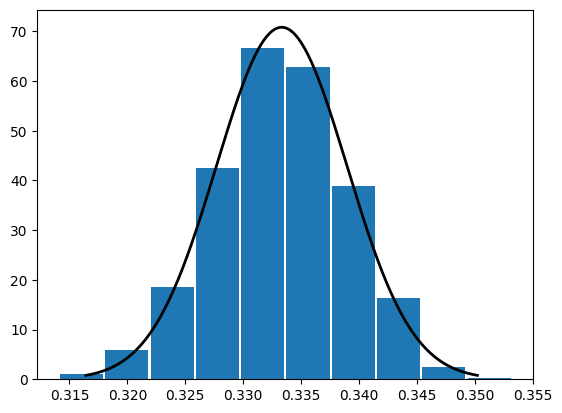

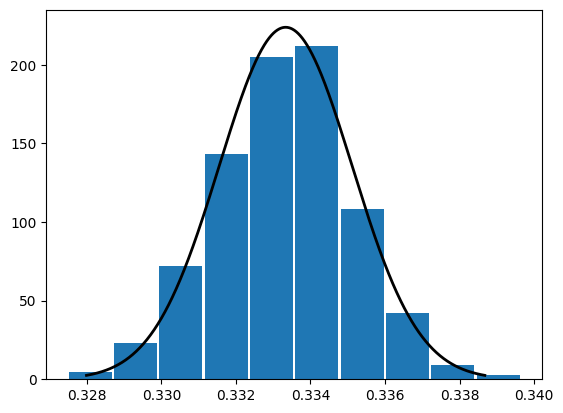

In [4]:
%matplotlib inline
#choose parameters a,b of the beta distribution a>0,b>0 
a=2;b=4
distribution = stats.beta(a, b)
replications=1000

n=10
means=runSimulation(distribution,replications,n)
plotCLT(distribution,means)

n=100
means=runSimulation(distribution,replications,n)
plotCLT(distribution,means)

n=1000
means=runSimulation(distribution,replications,n)
plotCLT(distribution,means)

n=10000
means=runSimulation(distribution,replications,n)
plotCLT(distribution,means)

# Question 2
Run a gradient algorithm to find the solution to x : Ax = b where b = (1, . . . , 1) ∈ Rp and
A ∈ Rp×p, p = 100 is the upper triangular matrix with only ones (hint: introduce a convenient
loss function). With a starting point x = 0, evaluate the rate of convergence of your algorithm

## Generic gradient descent function

In [5]:
def gradientdescent(A,b,stepsize,trueparam,derivative):
    xinit=np.zeros(A.shape[1])
    tol=0.01
    maxiter=50000
    
    xold=xinit
    error = 1
    i=0
    errors=np.zeros(maxiter)
    
    while(error>tol and i <maxiter):
        gradient=derivative(xold,A,b)
        xnew=xold- np.dot(stepsize, gradient)
        errors[i]= np.linalg.norm(xnew-trueparam)
        error = np.linalg.norm(A.dot(xnew)-b)
        xold=xnew
        i=i+1
    return xnew,errors[:i],i

## First idea
consider the derivative $A x - b$ with unkown objective function. In case that the matrix A had been symmetric the corresponding objective function would have been $x^T A x - x^T b$

In [6]:
def derivative(x, A, b):
    return A.dot(x)-b

We test this gradient descen algorithm with constant stepsize and we find that the squared difference between the estimated and true parameter decreases exponentially.

958


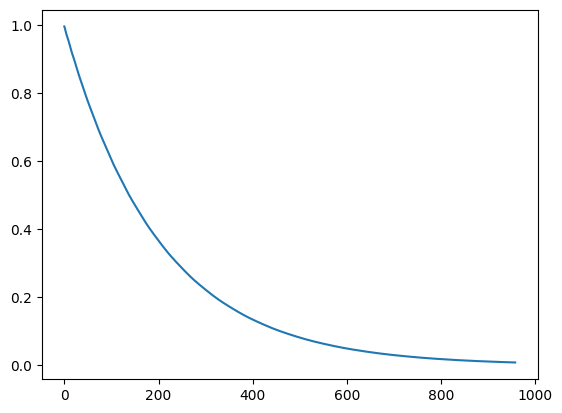

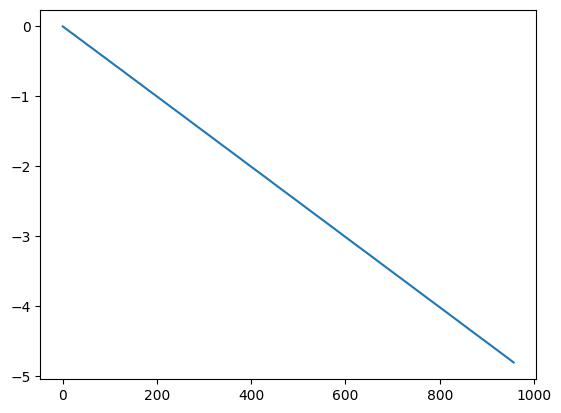

In [7]:
%matplotlib inline
p=100
A= np.triu(np.ones(p),k=0)
b= np.ones(p)
stepsize= 1/100

trueparam=np.linalg.inv(A).dot(b)

xhat,errors,maxiter=gradientdescent(A,b,stepsize,trueparam,derivative)
print(maxiter)

plt.figure()
plt.plot(range(maxiter),errors)
plt.show()
plt.figure()
plt.plot(range(maxiter),np.log(errors))
plt.show()

We also test the gradient descent method with the stepsize equal to the inverse of the hessian. This leads to the hessian equal to $A^{-1}$ and thus the gradient step becomes $x_{new}= x_{old} - A^{-1} ( A x_{old} - b) = x_{old}-x_{old}+ A^{-1} b= A^{-1} b$ and thus we just determine the matrix inverse

In [8]:
%matplotlib inline
p=1000
A= np.triu(np.ones(p),k=0)
b= np.ones(p)

stepsize= np.linalg.inv(A)

trueparam=np.linalg.inv(A).dot(b)

xhat,errors,maxiter=gradientdescent(A,b,stepsize,trueparam,derivative)
print(maxiter)

1


## Second idea
consider the objective function $||A x - b||$ with derivative equal to $A^T ( A x -b)$

In [9]:
def derivativeOLS(x, A, b):
    return A.T.dot(A.dot(x)-b)

We also use a constant stepsize but now we need to take the stepsize equal to one over the largest eigenvalue to have convergence. This unfortunately means that we use a significantly smaller stepsize and thus we need more iterations. however we still recover a exponential rate of convergence

In [10]:
p=100
A= np.triu(np.ones(p),k=0)
b= np.ones(p)

largest_eigen=np.max(np.linalg.eig(A.T.dot(A))[0])
print(largest_eigen)

4093.5604746853132


38385


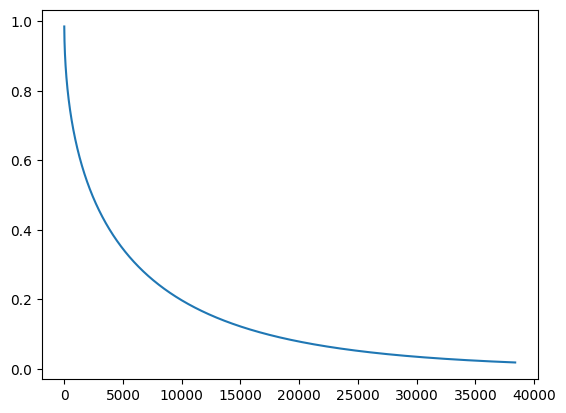

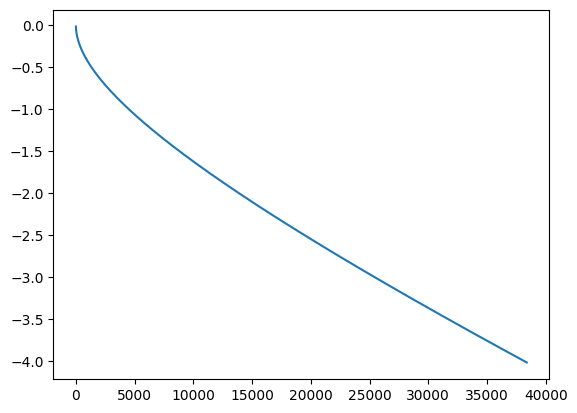

In [11]:
stepsize= 1/largest_eigen

trueparam=np.linalg.inv(A).dot(b)

xhat,errors,maxiter=gradientdescent(A,b,stepsize,trueparam,derivative=derivativeOLS)
print(maxiter)

plt.figure()
plt.plot(range(maxiter),errors)
plt.show()
plt.figure()
plt.plot(range(maxiter),np.log(errors))
plt.show()

Divergence if stepsize is equal to to 1/p

193


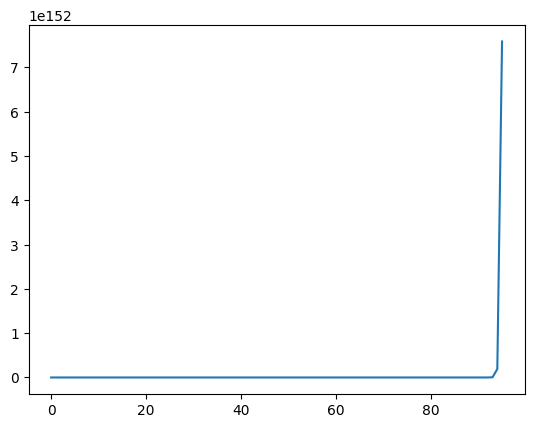

In [12]:
stepsize= 1/p

trueparam=np.linalg.inv(A).dot(b)

xhat,errors,maxiter=gradientdescent(A,b,stepsize,trueparam,derivative=derivativeOLS)
print(maxiter)

plt.figure()
plt.plot(range(maxiter),errors)
plt.show()

# Question 3
Run a stochastic a stochastic version of the previous algorithm (hint: randomize the loss function
using coordinate sampling)

Starting from the objective function $||Ax -b|| = \sum_{i=1}^p (\sum_{j=1}^p a_{ij}x_j - b_i)$ we only consider a subset of rows thus our derivative is equal to $C^T(C x - d)$ where $C$ and $d$ has a subset of the rows of $A$ and $b$ respectively. We furthermore use all data once in each iteration (called an epoch) and the rows used is dependent on the the batchsize.

In [13]:
def epoch(x, A, b,Nbatch,stepsize,bootstrap):
    p=A.shape[0]
    if (bootstrap):
        indices=np.random.choice(p,p)
    else:
        indices=np.arange(p)
        np.random.shuffle(indices)
    for i in range(Nbatch):
        rows=indices[math.floor(p/Nbatch*i):math.floor(p/Nbatch*(i+1))]
        Abatch= A[rows,:]
        bbatch=b[rows]
        gradient= Abatch.T.dot(Abatch.dot(x)-bbatch)
        x=x-stepsize*gradient
    return x


def stochasticGradientDescent(A,b,stepsize,trueparam,batchsize=1,bootstrap=False):
    xinit=np.zeros(A.shape[1])
    tol=0.01
    maxiter=10000
    
    xold=xinit
    error = 1
    i=0
    errors=np.zeros(maxiter)
    
    while(error>tol and i <maxiter):
        xnew=epoch(xold,A,b,batchsize,stepsize,bootstrap)
        errors[i]= np.linalg.norm(xnew-trueparam)
        error = np.linalg.norm(A.dot(xnew)-b)
        xold=xnew
        i=i+1
    return xnew,errors[:i],i


Using the stochastic gradient descent, we again observe an exponential rate of convergence. We furthemore overserve that we can use a significantly smaller stepsize without divergence

2809


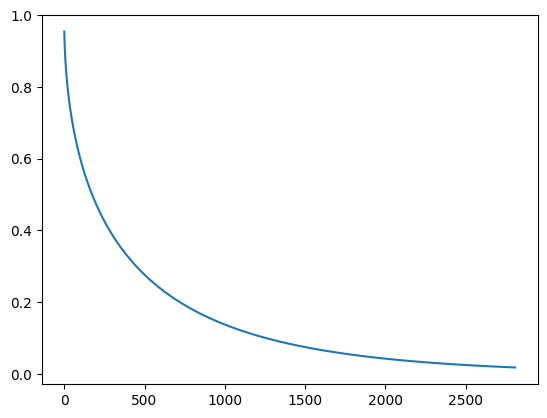

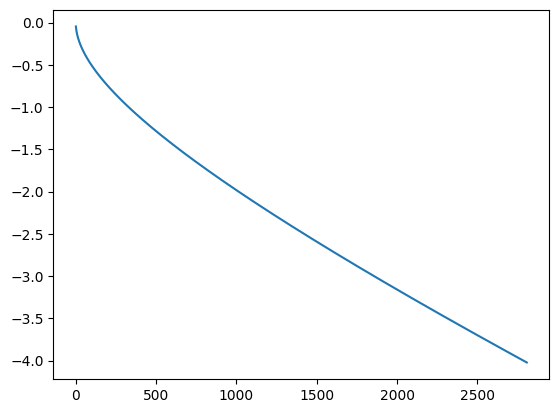

In [14]:
%matplotlib inline
p=100
A= np.triu(np.ones(p),k=0)
b= np.ones(p)
trueparam=np.linalg.inv(A).dot(b)
xhat,errors,maxiter=stochasticGradientDescent(A,b,1/300,trueparam,10,False)

print(maxiter)
plt.figure()
plt.plot(range(maxiter),errors)
plt.show()
plt.figure()
plt.plot(range(maxiter),np.log(errors))
plt.show()


A second idea is instead of using all data once, we create bootstrap samples in each epoch, we again see an exponential rate of convergence, however we see little benefit compared to the non-bootstrapped gradient descent

2730


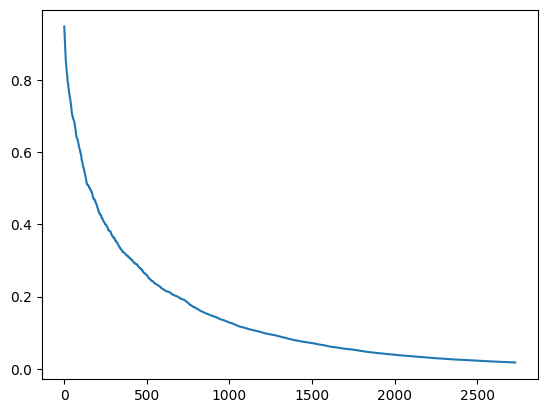

In [15]:
%matplotlib inline
p=100
A= np.triu(np.ones(p),k=0)
b= np.ones(p)
trueparam=np.linalg.inv(A).dot(b)
xhat,errors,maxiter=stochasticGradientDescent(A,b,1/300,trueparam,10,True)

print(maxiter)
plt.figure()
plt.plot(range(maxiter),errors)
plt.show()

# Question 4
Download the diabetes dataset from sklearn. Run and evaluate the nerest neigbor algorithm.
Compare the different values of k using a proper tools.

In [16]:
data,target=datasets.load_diabetes( return_X_y=True, as_frame=True, scaled=True)

In [17]:
X=np.array(data)
y=np.array(target)

19


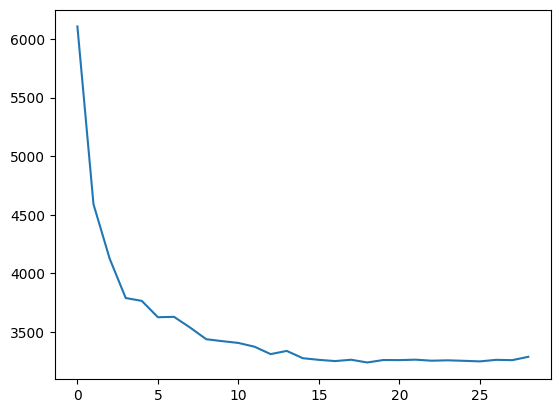

In [18]:
maxK=30
score=[]
nFold=10
kf = model_selection.KFold(n_splits=nFold)
for k in range(1,maxK):

    accuracy=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=KNN(n_neighbors=k).fit(X_train,y_train)
        
        accuracy.append(np.mean((y_test-model.predict(X_test))**2))
    score.append(np.mean(accuracy))
plt.plot(score)
print(np.argmin(score)+1)

We find that the optimal number of cluster is 19

# Question 5
Select the most important variables using the method of your choice.




Since we only have 10 features there are only $2^{10}=1024$ possible models we thus are able to consider all models for a given K (19) nearest neighbors. We do this by first creating a list of all possible variable combinations and then determining the mean squared error using k-fold, and finally selecting the best model

In [19]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))
models = list(powerset([0,1,2,3,4,5,6,7,8,9]))


In [20]:
score=[]


k=19

for var in models:
    #print(model)
    accuracy=[]
    score.append(np.mean(model_selection.cross_val_score(KNN(k), X[:,var], y=y, scoring='neg_mean_squared_error')))
best_index=np.argmax(score)
print(models[best_index])

(1, 2, 3, 6, 8, 9)


thus the model with parameters (1, 2, 3, 6, 8, 9) is optimal

# Question 6
Evaluate the nerest neigbor algorithm on different values of k based on the most important variables
(from the question before)

20


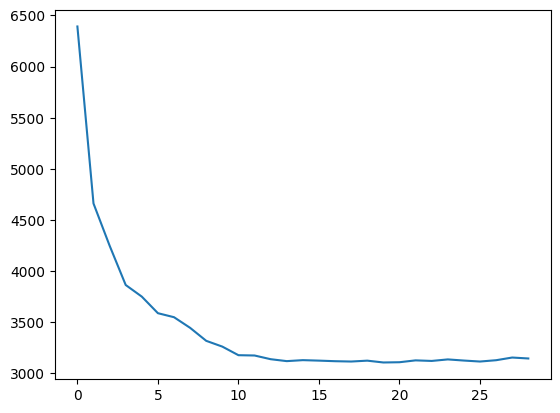

In [21]:
maxK=30
score=[]
nFold=10
Xselected=X[:,[1, 2, 3, 6, 8, 9]]
kf = model_selection.KFold(n_splits=nFold)
for k in range(1,maxK):

    accuracy=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = Xselected[train_index], Xselected[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=KNN(n_neighbors=k).fit(X_train,y_train)
        
        accuracy.append(np.mean((y_test-model.predict(X_test))**2))
    score.append(np.mean(accuracy))
plt.plot(score)
print(np.argmin(score)+1)

Thus 20 nearest neighbors is optimal for the sample using variables 1, 2, 3, 6, 8, 9

# Question 7
Run a recursive version of the nearest neigbour algorithm. Compare it to the standard version.

We create an algorithm under certain assumptions:
- We have an initial model with n datapoints
- We want to have predictions for p data points
- We want to update the predictions for the p datapoints based on m new observations
- We prefer faster execution over memory efficiency(we trade time complexity for space complexity)

Our algorithm is created as follows. During the predictions of the p datapoints based on the n initial observations, in addition to saving the prediction of a certain point we also save a tuple with the distance and value of the k closest points for each predictions. If we now want to update the prediction of the p datapoints based on m new observations, we only have to compare the new distances to the saved distances, and see which are smaller.

In [22]:
def initialpredictions(Xsample, ysample, Xpredict,k):
    p=Xpredict.shape[0]
    nn=[None]*p
    prediction=np.zeros((p,1))
    for i in range(p):
        distance=np.sum((Xsample-Xpredict[i,:])**2,axis=1)
        
        nearestneighbors = (distance).argsort()[:k]
        nearestneighbors = nearestneighbors.astype('int32')
        nn[i]=list(zip(distance[nearestneighbors],ysample[nearestneighbors]))
        #create predictions
        prediction[i]=np.mean([nn[i][j][1] for j in range(k)])
    return prediction,nn

def updatepredictions(Xnew,ynew,nnOld,Xpredict,k):
    p=Xpredict.shape[0]
    nnNew=[None]*p
    prediction=np.zeros((p,1))
    for i in range(p):
        #determine new points
        distance=np.sum((Xnew-Xpredict[i,:])**2,axis=1)
        
        nearestneighbors = (distance).argsort()[:k]
        nearestneighbors = nearestneighbors.astype('int32')
        nnNew[i]=list(zip(distance[nearestneighbors],ynew[nearestneighbors]))
        #merge old with new
        nnNew[i].extend(nnOld[i])
        #sort
        nnNew[i].sort(key=lambda point:point[0])
        #cut
        nnNew[i]=nnNew[i][:k]
        #update predictions
        prediction[i]=np.mean([nnNew[i][j][1] for j in range(k)])
    return prediction,nnNew

Small example of output:

In [23]:
sample=X[0:15,:]
predict=X[15:20,:]
newSample=X[20:30,:]
pred,nn=initialpredictions(sample, y[0:15],predict,2)
print(pred)
print(nn)
predNew,nnNew = updatepredictions(newSample,y[20:30],nn,predict,2)
print(predNew)
print(nnNew)

[[134.5]
 [182. ]
 [124. ]
 [170.5]
 [127. ]]
[[(0.03329955189988066, 63.0), (0.043658865889176245, 206.0)], [(0.022713391744937847, 179.0), (0.023013505421497264, 185.0)], [(0.015280248593053693, 63.0), (0.015514911908221561, 185.0)], [(0.010167711995786043, 206.0), (0.011317475148205887, 135.0)], [(0.0036648204885188847, 179.0), (0.008316296262241684, 75.0)]]
[[132.5]
 [132. ]
 [124. ]
 [126. ]
 [127. ]]
[[(0.03329955189988066, 63.0), (0.04244873073005715, 202.0)], [(0.02230818906670677, 85.0), (0.022713391744937847, 179.0)], [(0.015280248593053693, 63.0), (0.015514911908221561, 185.0)], [(0.004971028591422836, 184.0), (0.0063145561346224415, 68.0)], [(0.0036648204885188847, 179.0), (0.008316296262241684, 75.0)]]


## Results comparison
Check results from normal nearest neighbor vs iterated nearest neighbors: we find that the results are equal (as expected)

In [24]:
#split data in to testset and sample
Xpredict=X[:44];ypredict=y[:44]
Xtotal= X[44:];ytotal=y[44:]
Xinitial=Xtotal[:300];yinitial=ytotal[:300]
Xupdate=Xtotal[300:];yupdate=ytotal[300:]
k=15


totalPrediction,totalNN=initialpredictions(Xtotal,ytotal,Xpredict,k)
initialPrediction,initialNN=initialpredictions(Xinitial,yinitial,Xpredict,k)
updatePrediction,updateNN=updatepredictions(Xupdate,yupdate,initialNN,Xpredict,k)
np.array_equal(totalPrediction,updatePrediction)

True

## Time comparison
we also compare the computing time between the update vs a reestimation of the whole model

In [25]:
%timeit totalPrediction,totalNN=initialpredictions(Xtotal,ytotal,Xpredict,k)

2.15 ms ± 52.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit updatePrediction,updateNN=updatepredictions(Xupdate,yupdate,initialNN,Xpredict,k)

1.66 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


from 1.27 ms to 0.725 ms -> 43% decrease in running time. We expect and even bigger difference for increasing larger datasets. Fun fact: 0.7ms is about the time that a baseball remains in contact with a baseball bat